# U-net test with Keras

In [337]:
# specify random seed for replicating results
seed = 1337
import random
random.seed = seed
import numpy as np
np.random.seed = seed
import tensorflow as tf
tf.set_random_seed(seed)

import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from PIL import Image
from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

%matplotlib inline

/Users/Kazu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [314]:
# Utility function for plotting multiple images
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(imgs[i], cmap='gray')

### Loading data

In [279]:
TRAIN_PATH = '../../data/stage1_train/'
TEST_PATH = '../../data/stage1_test/'

# Should image be larger? What's the range of image sizes in dataset (see exploration kernels)
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

Dataset structure:

* stage1_train/
    * folders for each image
        * images/ : contains one png (not multiple, but then why is this called "images" plural?; see check below)
        * masks/ : individual png masks for each cell 
        
Ideally we won't just put masks on top of each other (e.g. with `max`) to get a single mask image, since we will lose borders between cells if we do this). We need to do some background pixel insertion + weighting, like in U-net paper. 

In [281]:
file_path = Path(TRAIN_PATH)
train_files = sorted(list(Path(file_path).iterdir()))
file_path = Path(TEST_PATH)
test_files = sorted(list(Path(file_path).iterdir()))

In [283]:
for file in train_files: 
    if len(list((file/'images').iterdir())) > 1:
        print('Some have more than one image! wtf does this mean')

In [745]:
# Read, process, and save entire dataset (do this once)
X_train = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool) # masks
names_train = []

for i, file in tqdm(enumerate(train_files), total=len(train_files)):
    name = str(files[0].absolute()).split('/')[-1]
    names_train.append(name)

    image_path = next((files[sample_idx]/'images').iterdir())
    img = np.asarray(Image.open(image_path).convert("RGB"))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    
    # TODO when loading these masks, recognize touching objects and deal with them 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in (files[sample_idx]/'masks').iterdir():
        mask_ = np.asarray(Image.open(mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[i] = mask
    
X_test = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
names_test = []

for i, file in tqdm(enumerate(test_files), total=len(test_files)):
    name = str(files[0].absolute()).split('/')[-1]
    names_test.append(name)

    image_path = next((files[sample_idx]/'images').iterdir())
    img = np.asarray(Image.open(image_path).convert("RGB"))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img
    
np.savez_compressed('dataset_square', X_train=X_train, Y_train=Y_train, X_test=X_test)
print('Done!')

100%|██████████| 65/65 [00:00<00:00, 107.70it/s]


Done!


In [751]:
# Load pre-processed (just for dimensions) dataset
npzfile = np.load('dataset_square.npz')
X_train = npzfile['X_train']
Y_train = npzfile['Y_train']
X_test = npzfile['X_test']

In [752]:
img = X_train[-1]
mask = Y_train[-1]
imgs2plot = [img, np.squeeze(mask)]

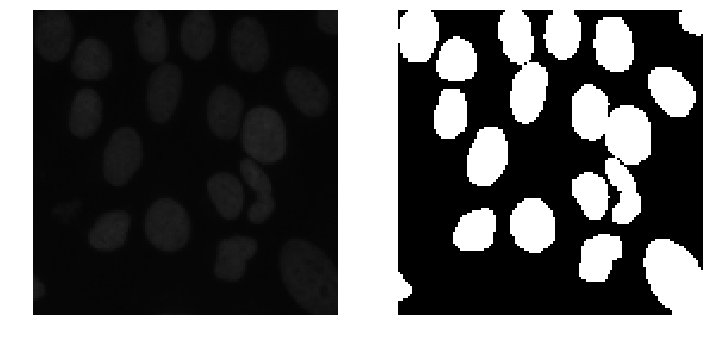

In [753]:
plots(imgs2plot)

### Data augmentation

The U-net paper suggests a random elastic deformation on the images. This is done by randomly sampling deformation directions at each pixel, then running a Gaussian filter over that deformation field to smooth it. 

In [796]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

# TODO make this cleaner

# Function to distort list of images (in the same way)
def elastic_transform(images, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     From: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    img_size = images[0].shape[:2]
    
    rand_x = (random_state.rand(*img_size) * 2 - 1)
    rand_y = (random_state.rand(*img_size) * 2 - 1)
    dx = gaussian_filter(rand_x, sigma) * alpha
    dy = gaussian_filter(rand_y, sigma) * alpha
    dz = np.zeros_like(dx)
    
    # Random affine
    center_square = np.float32(img_size) // 2
    square_size = min(img_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    rand_affine = random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    pts2 = pts1 + rand_affine
    M = cv2.getAffineTransform(pts1, pts2)
    
    images_distorted = []
    for i, img in enumerate(images):
        shape = img.shape
        channels = shape[2] 
        
        tile3 = lambda x, n: np.swapaxes(np.array([x]*n), 0, 2)
        dx_i, dy_i, dz_i = tile3(dx, channels), tile3(dy, channels), tile3(dz, channels)
        
        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.array([np.reshape(y+dy_i, (-1, 1)), np.reshape(x+dx_i, (-1, 1)), np.reshape(z, (-1, 1))])
                
        original_dtype = img.dtype
        img = img.astype(np.uint8)
        img = cv2.warpAffine(img, M, img_size[::-1], borderMode=cv2.BORDER_REFLECT_101).reshape(shape)
        img_distorted = map_coordinates(input=img, coordinates=indices, order=1, mode='reflect')
        img_distorted = img_distorted.astype(original_dtype).reshape(shape)
        images_distorted.append(img_distorted)

    return images_distorted

# Default parameters for reasonable amount of warp
def elastic_transform_default(imgs):
    dim = imgs[0].shape[1]
    return elastic_transform(imgs, alpha=dim*2, sigma=dim*0.08, alpha_affine=dim*0.08)

In [797]:
import cv2

# Function to draw a grid over image, to visualize elastic deformation
def draw_grid(im, grid_size):
    im_grid = np.copy(im)
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im_grid, (i, 0), (i, im.shape[0]), color=(100,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im_grid, (0, j), (im.shape[1], j), color=(100,))
    return im_grid

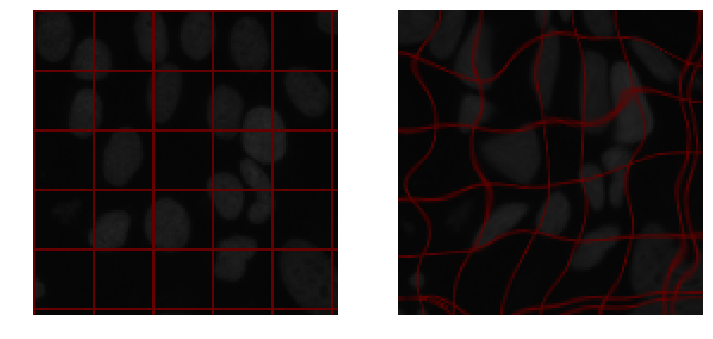

In [798]:
img_grid = draw_grid(img, int(img.shape[0]/5))
img_grid_warped = elastic_transform_default([img_grid])
plots([img_grid, img_grid_warped[0]]) 

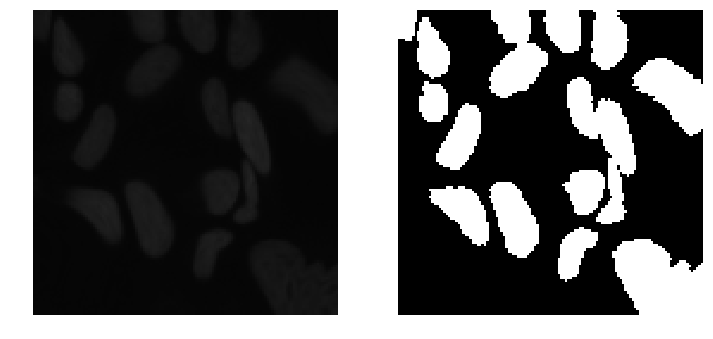

In [799]:
imgs = [img, mask]
imgs_warped = elastic_transform(imgs, alpha=img.shape[1] * 2, 
                               sigma=img.shape[1]*0.08, alpha_affine=img.shape[1] * 0.08)
img_warped = imgs_warped[0]
mask_warped = imgs_warped[1].squeeze() # because plots() can't handle (H, W, 1)
plots([img_warped, mask_warped])

In [803]:
# Augment dataset by adding distorted copies of each image

aug_multiplier = 2 # int, at least 2

X_train_aug = np.zeros((X_train.shape[0]*aug_multiplier, X_train.shape[1], 
                        X_train.shape[2], X_train.shape[3]), dtype=np.uint8)
X_train_aug[:X_train.shape[0]] = X_train

Y_train_aug = np.zeros((Y_train.shape[0]*aug_multiplier, Y_train.shape[1], 
                        Y_train.shape[2], Y_train.shape[3]), dtype=np.bool)

idx = X_train.shape[0]
for i in tqdm(range(X_train.shape[0])):
    for _ in range(aug_multiplier-1):
        aug_img = elastic_transform_default([X_train[i], Y_train[i]])
        X_train_aug[idx] = aug_img[0]
        Y_train_aug[idx] = aug_img[1]
        idx += 1
        
np.savez_compressed('dataset_aug', X_train_aug=X_train_aug, Y_train_aug=Y_train_aug, X_test=X_test)
print('Done!')

100%|██████████| 670/670 [00:16<00:00, 40.62it/s]


Done!


In [807]:
npzfile = np.load('dataset_aug.npz')
X_train_aug = npzfile['X_train_aug']
Y_train_aug = npzfile['Y_train_aug']
X_test = npzfile['X_test']

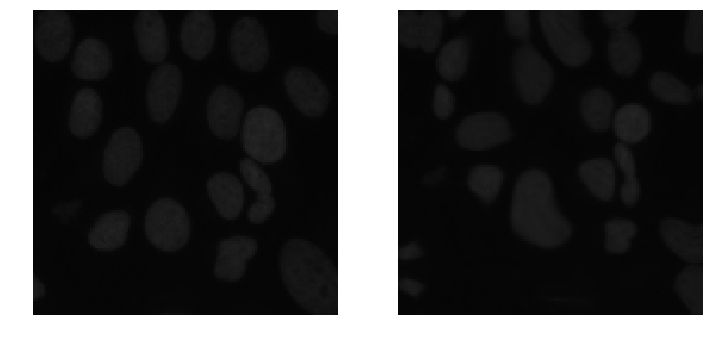

In [808]:
plots([X_train[-1], X_train_aug[-1]])

### Define and train U-net model

In [809]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [810]:
# Define IoU metric
# From: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
# TODO double-check this

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [812]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255 - 127.5) (inputs) # normalize to [-1, 1]

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
# model.summary()

In [830]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('models/with_elastic_deformations.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

# standard kernel baseline got loss 0.0668, mean_iou 0.8339, val_loss 0.0627, val_mean_iou 0.8343 with 50 epochs

Train on 603 samples, validate on 67 samples
Epoch 1/10
160/603 [======>.......................] - ETA: 4:05 - loss: 0.5964 - mean_iou: 1.4046e-07

KeyboardInterrupt: 

In [816]:
# Predict on train, val and test
# model_path = 'models/model-dsbowl2018-1.h5'
model_path = 'models/with_elastic_deformations.h5'

model = load_model(model_path, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions TODO WHY????
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

670/670 [==============================] - 81s 121ms/step


NameError: name 'sizes_test' is not defined

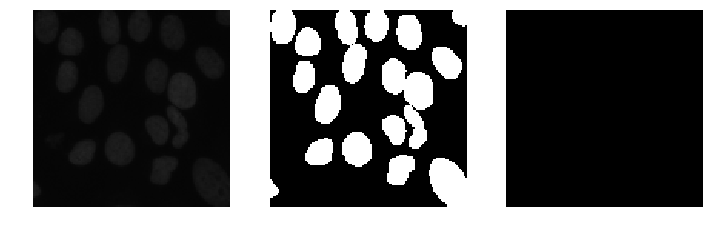

In [828]:
# Perform a sanity check on some random training samples
# TODO change this to _aug - need preds_train_t_aug
ix = random.randint(0, len(preds_train_t))
plots([X_train[ix], np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix])])
plt.show()

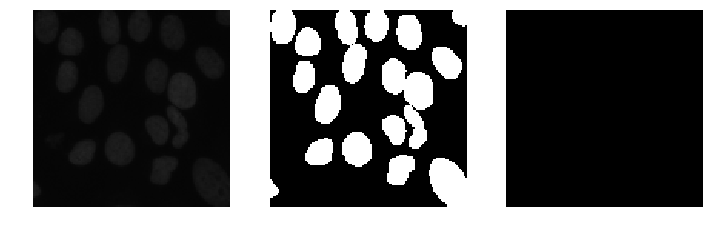

In [829]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plots([X_train[int(X_train.shape[0]*0.9):][ix], 
       np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]), 
       np.squeeze(preds_val_t[ix])])
plt.show()